### The code is continuation of the notebook **baseline.ipynb**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as functional
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


import pandas as pd
import matplotlib.pyplot as plt
#from model import Model
import numpy as np

In [ ]:
batch_size = 32
train_set = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#train_loader = DataLoader(dataset = train_set, batch_size= batch_size, shuffle = True)


#Creating validation set and training sets


index = list(range(len(train_set)))

#Train Set has size 60000, so we create validation set of size 10%
#print(index)
np.random.shuffle(index)
#print(index)
train_split = int(np.floor(0.9*60000))
#print(train_split)

training_set = Subset(train_set,index[:train_split])
validation_set = Subset(train_set,index[train_split:])
#print(len(training_set))
#print(len(validation_set))

training_loader = DataLoader(dataset=training_set,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size,shuffle=True)


# Creating test set
test_set = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
print("The size of training set is :",len(training_set))
print("The size of validation set is :",len(validation_set))
print("The size of testing set is :",len(test_set))

The size of training set is : 54000
The size of validation set is : 6000
The size of testing set is : 10000


torch.Size([32, 1, 28, 28])


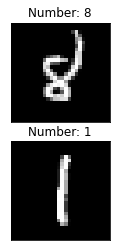

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

fig = plt.figure()
for i in range(2):
  plt.subplot(2,1,i+1)
  plt.imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Number: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net,self).__init__()
        self.layers1 = nn.Sequential(
        nn.Conv2d(1,12,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(12),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        #nn.Avg
        nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(24),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2)
      )
        self.layers2 = nn.Sequential(
          nn.Linear(in_features=24*7*7,out_features=30),
          nn.ReLU(),
          nn.Linear(in_features=30, out_features=10)
      )
    
    def forward(self,x):
        x=self.layers1(x)
        x=x.view(x.size(0),-1)
        x=self.layers2(x)
        return x


# Xavier-Glorot initialization of weights  
def glorot_weights(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
model_rms = CNN_Net()
model_rms.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()
optimizer1 = optim.RMSprop(params=model_rms.parameters(), lr=0.001)
lr_scheduler1 = optim.lr_scheduler.StepLR(optimizer=optimizer1 , step_size=10, gamma=0.1)


In [ ]:
model_adam = CNN_Net()
model_adam.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(params=model_adam.parameters(), lr=0.05)
lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer=optimizer2 , step_size=10, gamma=0.1)

In [ ]:
model_nesterov = CNN_Net()
model_nesterov.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(params=model_nesterov.parameters(), lr=0.05)
lr_scheduler3= optim.lr_scheduler.StepLR(optimizer=optimizer3 , step_size=10, gamma=0.1)

In [ ]:
print("Training the CNN Model for RMSProp :")
number_of_epochs = 20
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss1 = []
avg_training_accuracy1 = []

avg_validation_loss1 = []
avg_validation_accuracy1 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model_rms.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer1.zero_grad()
        
        output = model_rms(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer1.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy1.append(np.mean(batch_accuracy))
    avg_training_loss1.append(training_loss/(i+1))
    
    model_rms.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model_rms(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy1.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss1.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model_rms.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler1.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy1)
    print("\nTraining Loss :",avg_training_loss1)
    
    print("\nValidation Accuracy :",avg_validation_accuracy1)
    print("\nValidation Loss :",avg_validation_loss1)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy1))
print("\nThe average training loss is :",np.mean(avg_training_loss1))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy1))
print("\nThe average validation loss is :",np.mean(avg_validation_loss1))

Training the CNN Model for RMSProp :
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.9463307168246445]

Training Loss : [0.1899912238545314]

Validation Accuracy : [0.9765625]

Validation Loss : [0.07632232233609489]

Epoch is : 2

Training Accuracy : [0.9463307168246445, 0.9638625592417062]

Training Loss : [0.1899912238545314, 0.061027309936878875]

Validation Accuracy : [0.9765625, 0.9745678191489362]

Validation Loss : [0.07632232233609489, 0.09027327946573001]

Epoch is : 3

Training Accuracy : [0.9463307168246445, 0.9638625592417062, 0.9711566943127962]

Training Loss : [0.1899912238545314, 0.061027309936878875, 0.04555767668875349]

Validation Accuracy : [0.9765625, 0.9745678191489362, 0.9771165780141844]

Validation Loss : [0.07632232233609489, 0.09027327946573001, 0.053671199830553615]

Epoch is : 4

Training Accuracy : [0.9463307168246445, 0.9638625592417062, 0.9711566943127962, 0.9754285767180095]

Training Lo

The curves for losses of training data and validation data for RMSProp are :


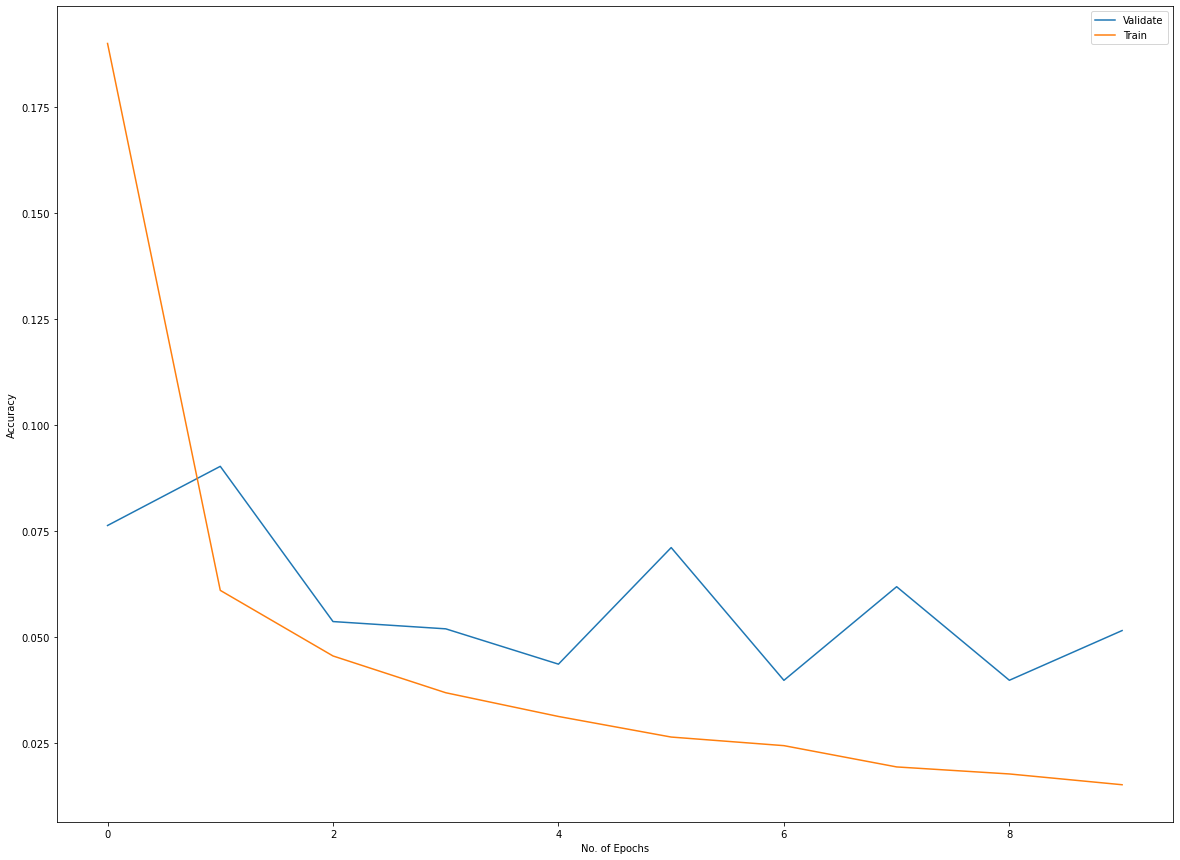

In [ ]:
print("The curves for losses of training data and validation data for RMSProp are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss1,label="Validate")
plt.plot(avg_training_loss1,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for RMSProp are :


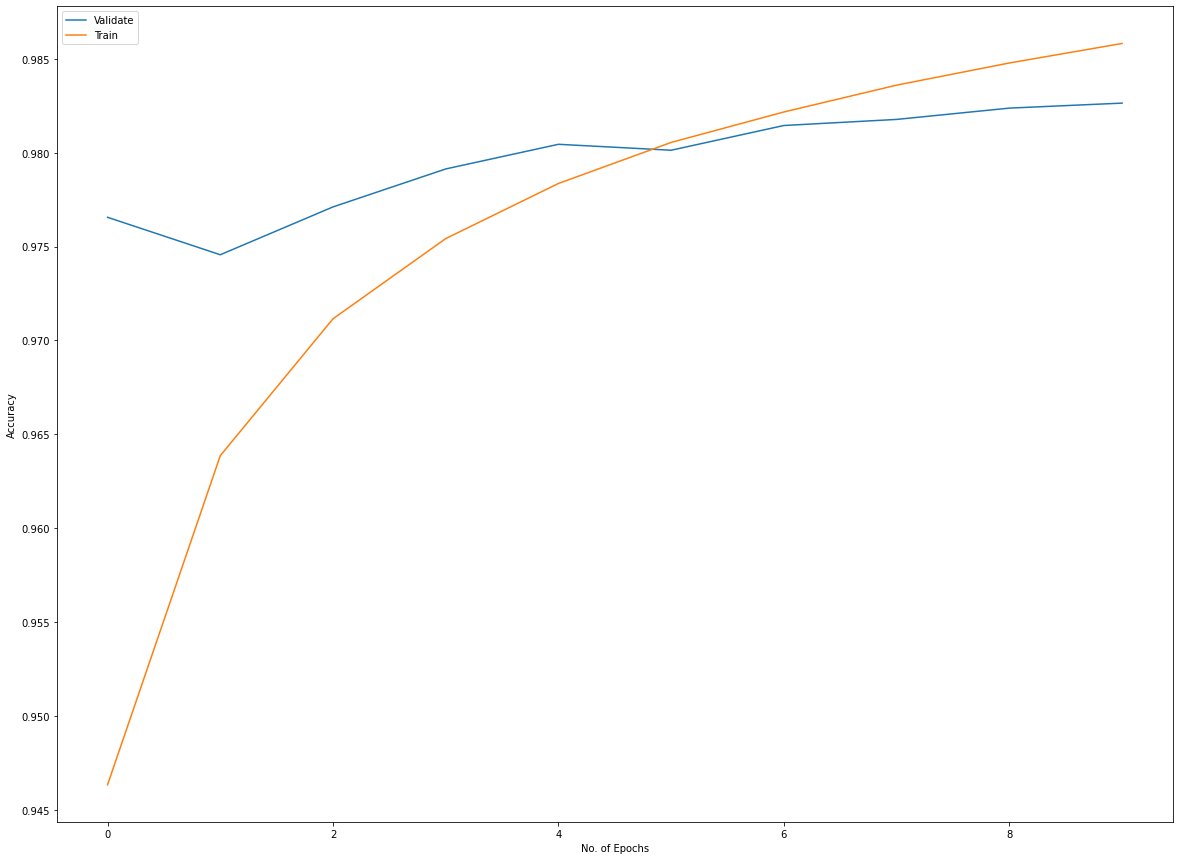

In [ ]:
print("The curves for accuracy of training data and validation data for RMSProp are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy1,label="Validate")
plt.plot(avg_training_accuracy1,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training the CNN Model for Adam :")
number_of_epochs = 20
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss2 = []
avg_training_accuracy2 = []

avg_validation_loss2 = []
avg_validation_accuracy2 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model_adam.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer2.zero_grad()
        
        output = model_adam(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer2.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy2.append(np.mean(batch_accuracy))
    avg_training_loss2.append(training_loss/(i+1))
    
    model_adam.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model_adam(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy2.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss2.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model_adam.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler2.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy2)
    print("\nTraining Loss :",avg_training_loss2)
    
    print("\nValidation Accuracy :",avg_validation_accuracy2)
    print("\nValidation Loss :",avg_validation_loss2)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy2))
print("\nThe average training loss is :",np.mean(avg_training_loss2))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy2))
print("\nThe average validation loss is :",np.mean(avg_validation_loss2))

Training the CNN Model for Adam :
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.9444609004739336]

Training Loss : [0.1796867619989985]

Validation Accuracy : [0.9752327127659575]

Validation Loss : [0.08413919362306417]

Epoch is : 2

Training Accuracy : [0.9444609004739336, 0.962057538507109]

Training Loss : [0.1796867619989985, 0.0668475693494859]

Validation Accuracy : [0.9752327127659575, 0.979970079787234]

Validation Loss : [0.08413919362306417, 0.050071559409224524]

Epoch is : 3

Training Accuracy : [0.9444609004739336, 0.962057538507109, 0.9694966923380727]

Training Loss : [0.1796867619989985, 0.0668475693494859, 0.052478031028112174]

Validation Accuracy : [0.9752327127659575, 0.979970079787234, 0.980219414893617]

Validation Loss : [0.08413919362306417, 0.050071559409224524, 0.06337790845963297]

Epoch is : 4

Training Accuracy : [0.9444609004739336, 0.962057538507109, 0.9694966923380727, 0.97348470823459

The curves for losses of training data and validation data for Adam are :


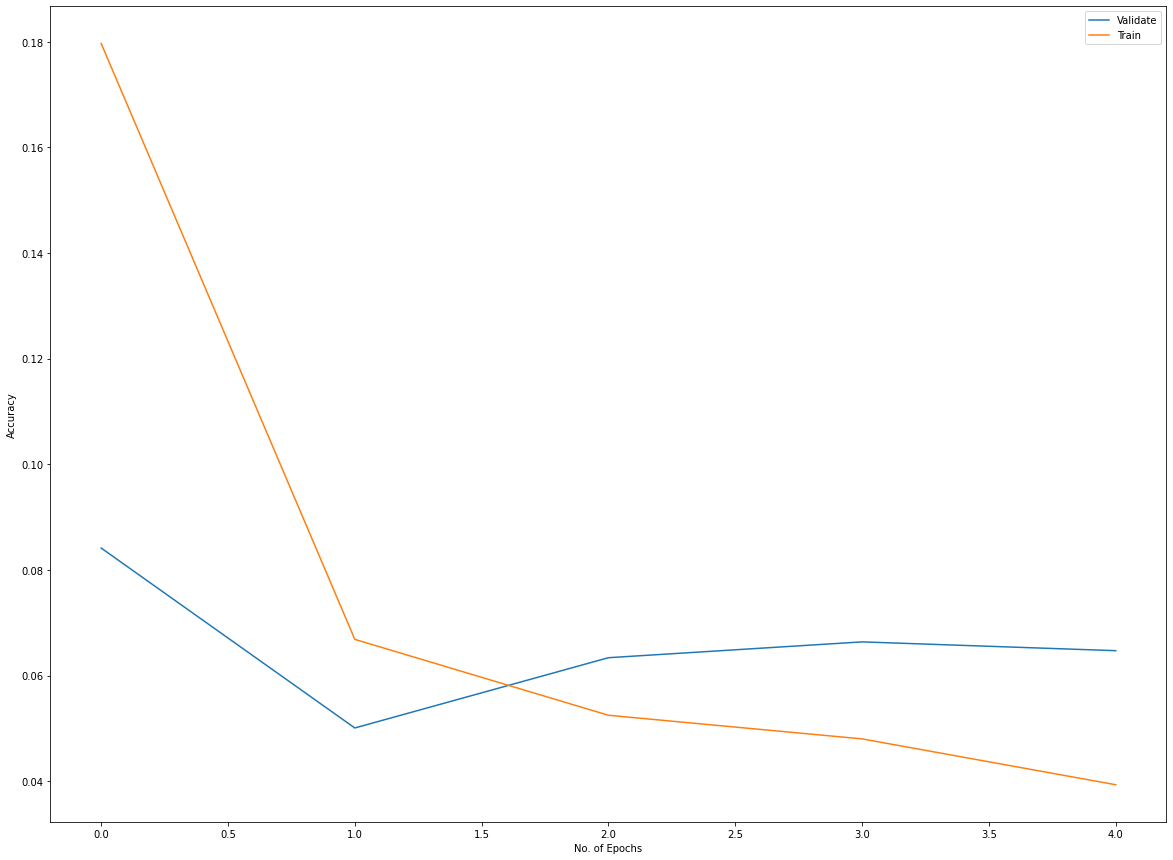

In [ ]:
print("The curves for losses of training data and validation data for Adam are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss2,label="Validate")
plt.plot(avg_training_loss2,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for Adam are :


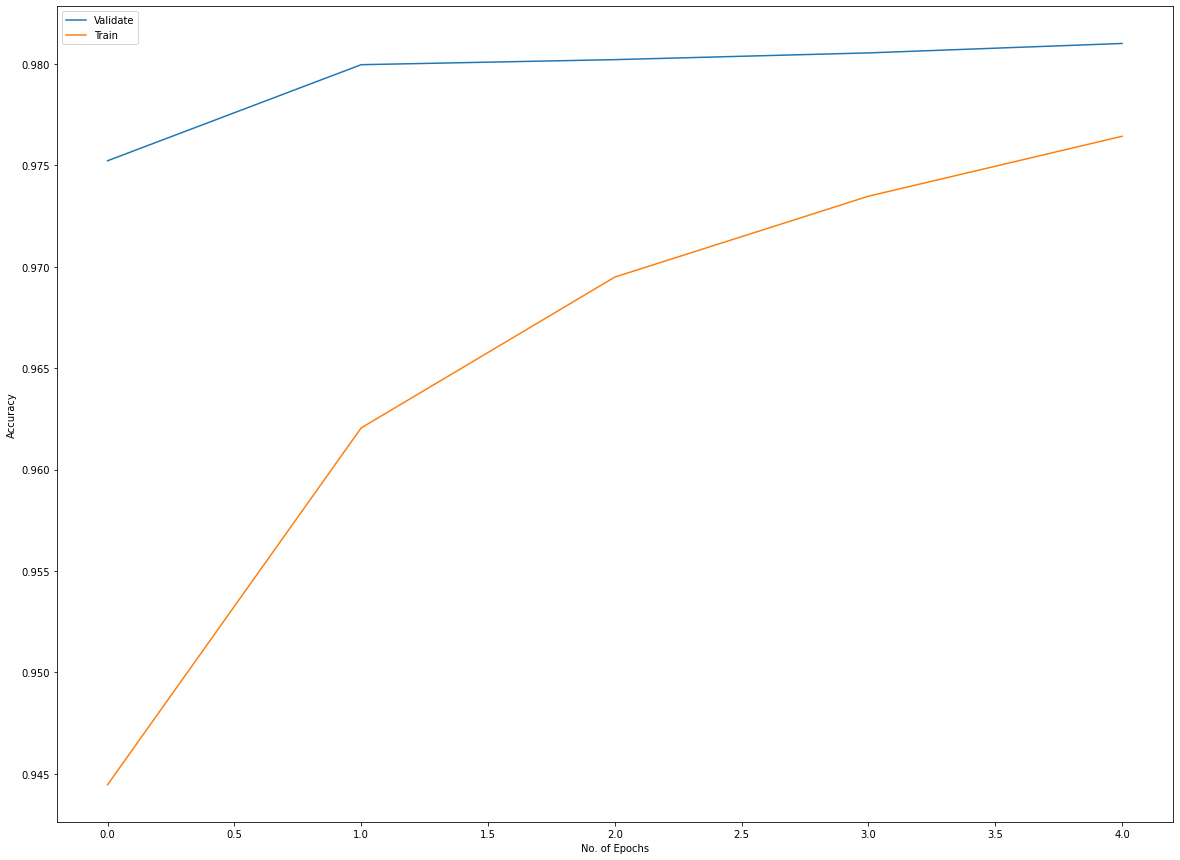

In [ ]:
print("The curves for accuracy of training data and validation data for Adam are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy2,label="Validate")
plt.plot(avg_training_accuracy2,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training the CNN Model for Nesterov :")
number_of_epochs = 20
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss3 = []
avg_training_accuracy3 = []

avg_validation_loss3 = []
avg_validation_accuracy3 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model_nesterov.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer3.zero_grad()
        
        output = model_nesterov(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer3.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy3.append(np.mean(batch_accuracy))
    avg_training_loss3.append(training_loss/(i+1))
    
    model_nesterov.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model_nesterov(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy3.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss3.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model_nesterov.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler3.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy3)
    print("\nTraining Loss :",avg_training_loss3)
    
    print("\nValidation Accuracy :",avg_validation_accuracy3)
    print("\nValidation Loss :",avg_validation_loss3)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy3))
print("\nThe average training loss is :",np.mean(avg_training_loss3))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy3))
print("\nThe average validation loss is :",np.mean(avg_validation_loss3))

Training the CNN Model for Nesterov :
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.91745038507109]

Training Loss : [0.2543409631476667]

Validation Accuracy : [0.9768949468085106]

Validation Loss : [0.07945724167276491]

Epoch is : 2

Training Accuracy : [0.91745038507109, 0.9470990077014217]

Training Loss : [0.2543409631476667, 0.07778906251238471]

Validation Accuracy : [0.9768949468085106, 0.9764793882978723]

Validation Loss : [0.07945724167276491, 0.07954028871237359]

Epoch is : 3

Training Accuracy : [0.91745038507109, 0.9470990077014217, 0.9583641883886256]

Training Loss : [0.2543409631476667, 0.07778906251238471, 0.06225015802409746]

Validation Accuracy : [0.9768949468085106, 0.9764793882978723, 0.9780031028368794]

Validation Loss : [0.07945724167276491, 0.07954028871237359, 0.06609394858427782]

Epoch is : 4

Training Accuracy : [0.91745038507109, 0.9470990077014217, 0.9583641883886256, 0.9647234152843

The curves for losses of training data and validation data for Nesterov are :


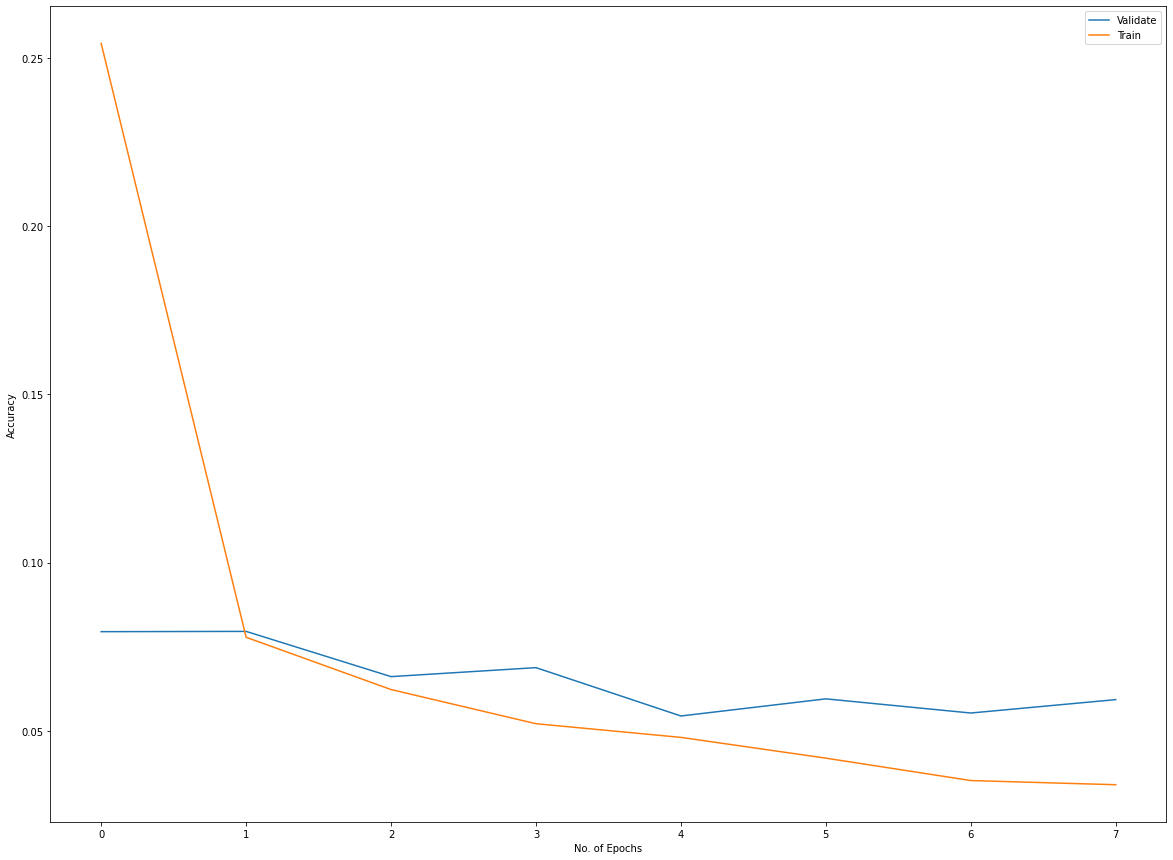

In [ ]:
print("The curves for losses of training data and validation data for Nesterov are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss3,label="Validate")
plt.plot(avg_training_loss3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for Nesterov are :


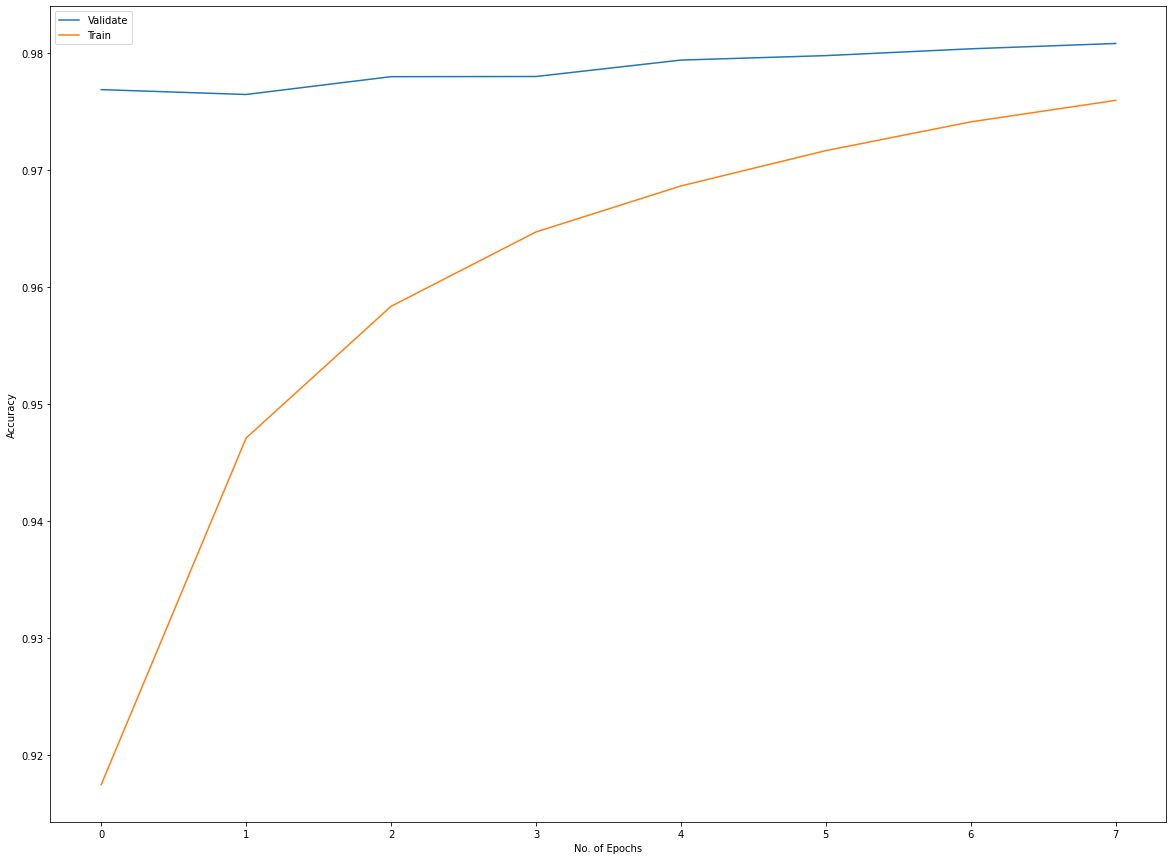

In [ ]:
print("The curves for accuracy of training data and validation data for Nesterov are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy3,label="Validate")
plt.plot(avg_training_accuracy3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Testing CNN Model for RMSProp:")
model_rms.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model_rms(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for RMSProp:

The accuracy after testing the CNN model is : 0.9864217252396166

The confusion matrix for test dataset is :
     0     1     2     3    4    5    6    7    8    9
0  972     1     3     1    0    0    2    0    1    0
1    0  1126     1     1    0    0    3    0    4    0
2    1     1  1026     1    0    0    0    2    1    0
3    0     0     1  1006    0    2    0    0    1    0
4    0     0     0     0  974    0    1    0    2    5
5    2     0     0     7    0  881    2    0    0    0
6    5     2     1     0    3    3  941    0    3    0
7    0     6    14     2    4    0    0  994    3    5
8    2     0     8     1    0    3    0    1  958    1
9    0     1     1     3    9    4    0    2    3  986


In [ ]:
print("Testing CNN Model for Adam:")
model_adam.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model_adam(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for Adam:

The accuracy after testing the CNN model is : 0.9821285942492013

The confusion matrix for test dataset is :
     0     1     2    3    4    5    6     7    8    9
0  975     0     3    0    0    0    1     1    0    0
1    0  1131     1    1    1    1    0     0    0    0
2    1     3  1024    0    0    0    0     3    0    1
3    0     1     8  998    0    3    0     0    0    0
4    0     0     0    0  975    0    3     1    1    2
5    0     0     0    9    0  880    3     0    0    0
6    2     2     1    0    3    3  947     0    0    0
7    0    10     5    2    2    0    0  1007    1    1
8    8     2    17    6    0    1   11     1  924    4
9    5     3     2   11   13    6    0     9    0  960


In [ ]:
print("Testing CNN Model for Nesterov:")
model_nesterov.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model_nesterov(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for Nesterov:

The accuracy after testing the CNN model is : 0.9840255591054313

The confusion matrix for test dataset is :
     0     1     2    3    4    5    6     7    8    9
0  973     0     1    1    0    0    5     0    0    0
1    5  1120     4    1    0    0    1     3    1    0
2    1     1  1018    2    0    0    0     6    4    0
3    0     0     4  998    0    5    0     0    3    0
4    0     1     0    0  973    0    1     0    1    6
5    0     0     0    4    0  872    3     1   12    0
6    1     3     0    0    4    1  942     0    7    0
7    0     3     8    2    0    0    0  1013    2    0
8    1     1     1    0    0    1    1     0  969    0
9    1     0     1    4   10    5    0     7   18  963


In this model, we have checked for three different optimizers which are: RMSProp, Adam and Nesterov. We have used the same CNN architecture as the one used for Batch Normalization.
However we initialized the learning rate for RMSProp as 0.001 since we were getting accuracy of 50% for 0.005 rate. We kept the learning rate as 0.05 for other optimizers.
After training the models for all optimizers on training and validation data, we plotted their learning curves. From these learning curves, we can say that all the models reached early stopping before the 10th epoch and losses reduced with increase in epochs and accuracy increased with more epochs. We set the patience factor as 3 here.
Using the best models, we run them on our test data and got:
1. Accuracy for RMSProp : 98.64%
2. Accuracy for Adam : 98.21%
3. Accuracy for Nesterov : 98.40% 


### Reference Used:
1. https://pytorch.org/docs/stable/optim.html